# Tutorial 5: Diffusion-based multimodal exploration of subtrajectories

Tutorials 4 and 5 study a human bone marrow dataset by [Mimitou et al., 2021](https://www.nature.com/articles/s41587-021-00927-2) showing the differentiation of hematopoietic stem cells to multiple developmental fates.

Building developmental single-cell atlases involves refined analysis of developmental subtrajectories from data consisting of multiple distinct lineages and cell types unrelated directly to a subtrajectory of interest. Typically, such analysis entails clustering all cells, manual annotation of cell clusters, and supervised extraction of cell clusters that may belong to the studied subtrajectory. In this tutorial, you will select a cell subpopulation and apply a multimodal diffusion process to trace trajectories related to it using Ocelli.

## Loading data and processing data

Download data available on [figshare](https://doi.org/10.6084/m9.figshare.28303928.v1) and import necessary packages.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import ocelli as oci
import anndata as ad
import numpy as np
from scipy.sparse import csr_matrix
from matplotlib.colors import LinearSegmentedColormap

! wget --content-disposition https://figshare.com/ndownloader/articles/28303928/versions/1
! unzip -o 28303928.zip
! rm 28303928.zip

--2025-01-29 18:43:00--  https://figshare.com/ndownloader/articles/28303928/versions/1
54.170.28.5, 52.17.87.113, 2a05:d018:1f4:d003:6dec:dfbb:5bc1:fcf0, ...
connected. to figshare.com (figshare.com)|54.170.28.5|:443... 
HTTP request sent, awaiting response... 200 OK
Length: 37581543 (36M) [application/zip]
Saving to: ‘28303928.zip’

28303928.zip        100%[===================>]  35.84M  10.8MB/s    in 3.3s    

2025-01-29 18:43:04 (10.8 MB/s) - ‘28303928.zip’ saved [37581543/37581543]

Archive:  28303928.zip
 extracting: bmmc_asapseq_atac_hscs.h5ad  
 extracting: bmmc_asapseq_atac.h5ad  
 extracting: bmmc_asapseq_prot_hscs.h5ad  
 extracting: bmmc_asapseq_prot.h5ad  


Prepare data as in tutorial 4.

In [2]:
atac = oci.read.h5ad('bmmc_asapseq_atac.h5ad')
prot = oci.read.h5ad('bmmc_asapseq_prot.h5ad')

# create a joint AnnData object
bmmc = ad.AnnData(csr_matrix(([],([],[])), shape=(10927, 1)))

bmmc.obsm['atac'] = atac.obsm['X_lda']
bmmc.obsm['prot'] = prot.obsm['X_lda']
bmmc.uns['modalities'] = ['atac', 'prot']

bmmc.obs.index = list(atac.obs.index)
bmmc.obs['celltype'] = list(atac.obs['celltype'])

## Multimodal Diffusion Maps

Repeat the MDM training procedure from tutorial 4. For multimodal diffusion in later steps, Ocelli needs eigenvectors and eigenvalues of the multimodal Markov matrix. To save them in the `bmmc` object, set `save_eigvec=True` and `save_eigval=True`.

In [3]:
oci.pp.neighbors(bmmc, n_neighbors=70, n_jobs=50, verbose=True)
oci.tl.modality_weights(bmmc, random_state=17, n_jobs=50, verbose=True)
oci.tl.MDM(bmmc, n_components=10, random_state=17, save_eigvec=True, 
           save_eigval=True, n_jobs=50, verbose=True)

oci.pp.neighbors(bmmc, x=['X_mdm'], n_neighbors=20, n_jobs=50, verbose=True)
oci.tl.neighbors_graph(bmmc, x='X_mdm', n_edges=20, verbose=True)
oci.tl.fa2(bmmc, n_components=2, n_jobs=50, random_state=142, n_iter=20000,
           linlogmode=True, flags='--jitterTolerance 0.1 --scalingRatio 0.01 '\
           '--outboundAttractionDistribution true')

[atac]	70 nearest neighbors calculated.
[prot]	70 nearest neighbors calculated.


2025-01-29 18:43:10,012	INFO worker.py:1518 -- Started a local Ray instance.


Multimodal weights estimated.


2025-01-29 18:43:15,991	INFO worker.py:1518 -- Started a local Ray instance.


[atac]	Unimodal Markov chain calculated.
[prot]	Unimodal Markov chain calculated.
Multimodal Markov chain calculated.
Eigendecomposition finished.
10 Multimodal Diffusion Maps components calculated.
[X_mdm]	20 nearest neighbors calculated.
Nearest neighbors-based graph constructed.


Jan 29, 2025 6:43:29 PM org.netbeans.modules.masterfs.watcher.Watcher getNotifierForPlatform
INFO: Native file watcher is disabled
Jan 29, 2025 6:43:29 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Nodes loaded: 10,927 (10,927 added)
Jan 29, 2025 6:43:29 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Edges loaded: 218,540 (143,249 added)


*************************25%
*************************50%
*************************75%
*************************100%
Time = 252.694s


## Multimodal diffusion of hematopoietic stem cells

To do so, create a vector with values equal to 1 for HSCs and 0 otherwise, then run the multimodal diffusion to monitor the spread of initial cell set to phenotypically related cells.

First, recall where HSCs are located.

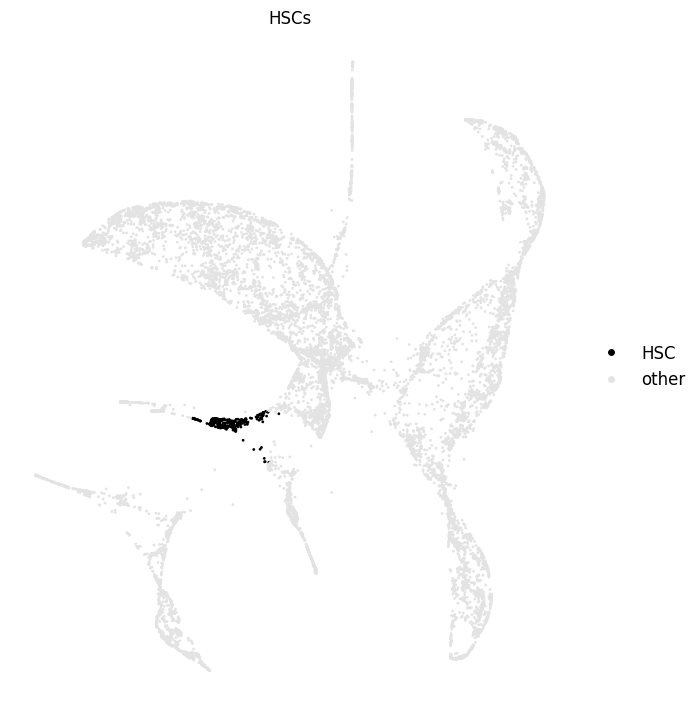

In [4]:
bmmc.obs['HSCs'] = ['HSC' if val == 'HSCs' else 'other' for val in bmmc.obs['celltype']]

oci.pl.scatter(bmmc, x='X_fa2', c='HSCs', cdict={'HSC': 'black', 'other': '#e3e3e3'}, 
               figsize=(7, 7), s=4, fontsize=12)

Create a vector with 1s assigned to HSCs and 0s to all other cells. Then, create an AnnData object `bmmc_diff` with this vector as `bmmc_diff.X`.

In [5]:
d = {'HSC': 1, 'other': 0}

bmmc_diff = ad.AnnData(np.asarray([[d[v]] for v in bmmc.obs.HSCs], dtype=np.float32))

# add eigenvetors, eigenvalues and 2D embedding to the AnnData object
bmmc_diff.uns['eigenvalues'] = bmmc.uns['eigenvalues']
bmmc_diff.uns['eigenvectors'] = bmmc.uns['eigenvectors']
bmmc_diff.obsm['X_fa2'] = bmmc.obsm['X_fa2']

Now you can run multimodal diffusion on `bmmc_diff`. Do it for multiple steps `t` to see how the trajectory signal propagates.

In [6]:
for t in [1, 10, 20]:
    # create a bmmc_diff copy not to overwrite its data
    bmmc_diff_copy = bmmc_diff.copy()
    
    # run the diffusion with selected t
    oci.tl.imputation(bmmc_diff_copy, t=t)
    
    # save the diffusion output
    bmmc_diff.obs['diff_t{}'.format(t)] = bmmc_diff_copy.X

bmmc_diff

AnnData object with n_obs × n_vars = 10927 × 1
    obs: 'diff_t1', 'diff_t10', 'diff_t20'
    uns: 'eigenvalues', 'eigenvectors'
    obsm: 'X_fa2'

Plot the diffused signal at `t=1`, `t=10`, and `t=20`.

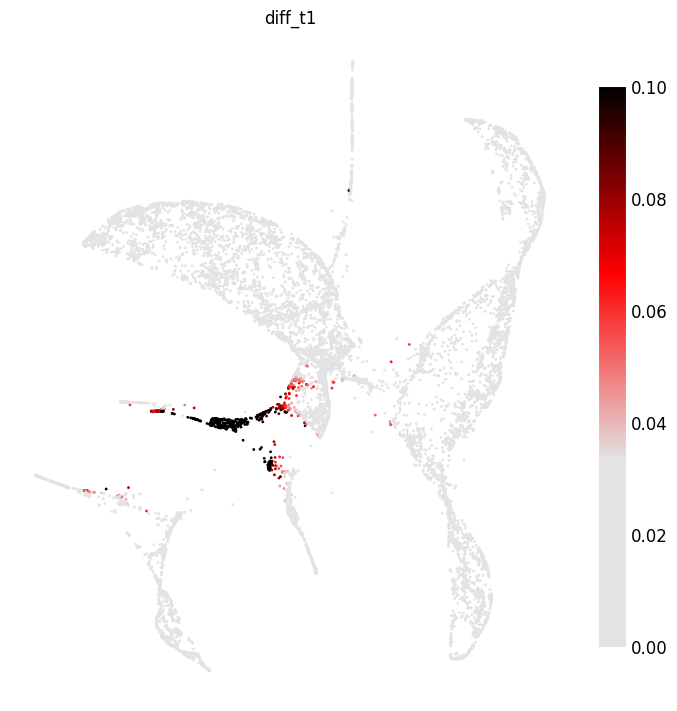

In [7]:
cmap = LinearSegmentedColormap.from_list('custom', ['#e3e3e3','#e3e3e3', '#ff0000', '#000000'], N=256)

oci.pl.scatter(bmmc_diff, x='X_fa2', c='diff_t1', cmap=cmap,
               figsize=(7, 7), s=4, fontsize=12, vmin=0, vmax=0.1)

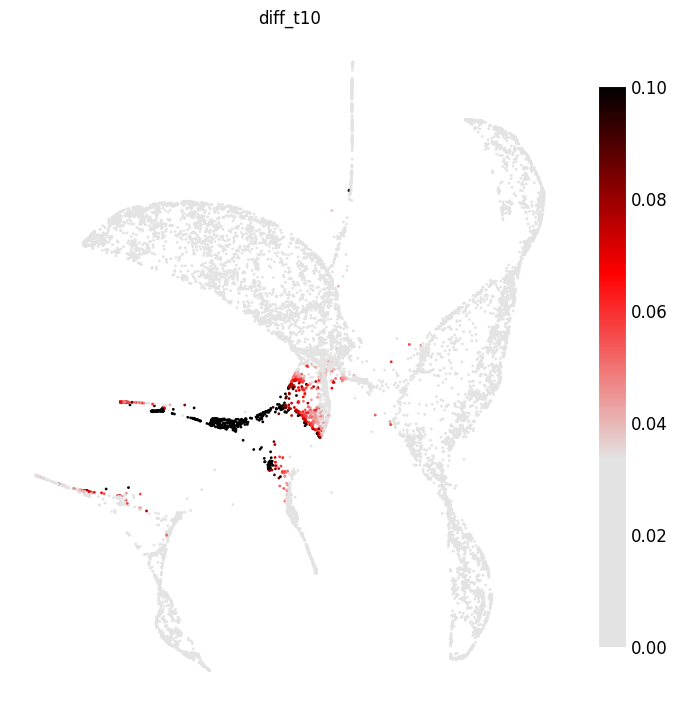

In [8]:
oci.pl.scatter(bmmc_diff, x='X_fa2', c='diff_t10', cmap=cmap,
               figsize=(7, 7), s=4, fontsize=12, vmin=0, vmax=0.1)

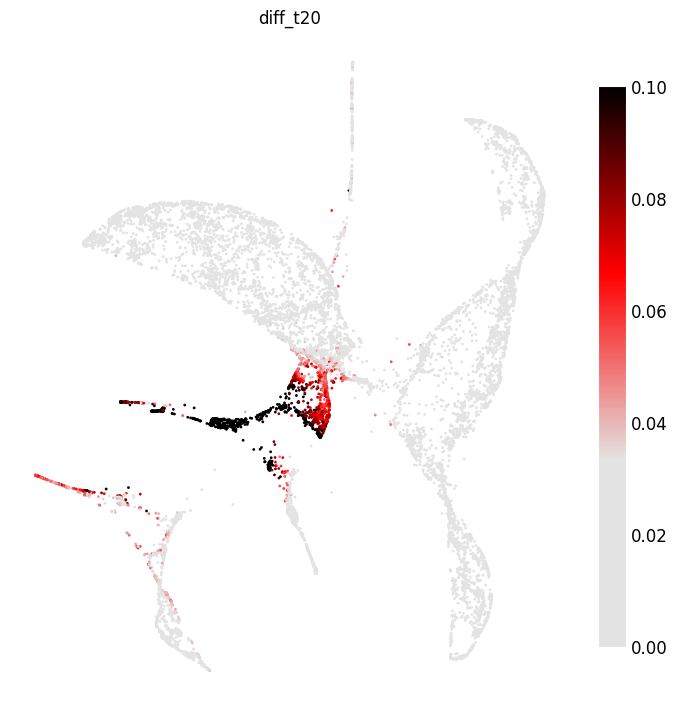

In [9]:
oci.pl.scatter(bmmc_diff, x='X_fa2', c='diff_t20', cmap=cmap,
               figsize=(7, 7), s=4, fontsize=12, vmin=0, vmax=0.1)

In order to examine only trajectories around HSCs, select cells in close developmental proximity to HSCs.

In [10]:
# select cells which had a high diffused signal and t=20
bmmc_diff = bmmc_diff[bmmc_diff.obs['diff_t20'] > 0.055]

bmmc_diff

View of AnnData object with n_obs × n_vars = 1451 × 1
    obs: 'diff_t1', 'diff_t10', 'diff_t20'
    uns: 'eigenvalues', 'eigenvectors'
    obsm: 'X_fa2'

This results in 1,451 cells. Load the raw data for this subset and generate a new multimodal embedding to explore trajectories at a higher resolution.

## Finding subtrajectories around HSCs

Compute the MDM embedding. Load raw data and find LDA embeddings of both modalities. For simplicity, we provide annotated matrices with precomputed topics.

In [11]:
#atac = oci.read.h5ad('bmmc_asapseq_atac.h5ad')[bmmc_diff.obs.index]
#oci.pp.lda(atac, n_components=15, max_iter=30, random_state=17, n_jobs=50, verbose=1)

#prot = oci.read.h5ad('bmmc_asapseq_prot.h5ad')[bmmc_diff.obs.index]
#oci.pp.lda(prot, n_components=15, max_iter=30, random_state=17, n_jobs=50, verbose=1)

atac = oci.read.h5ad('bmmc_asapseq_atac_hscs.h5ad')
prot = oci.read.h5ad('bmmc_asapseq_prot_hscs.h5ad')

# create a joint AnnData object
bmmc = ad.AnnData(csr_matrix(([],([],[])), shape=(atac.shape[0], 1000)))
bmmc.obsm['atac'] = atac.obsm['X_lda']
bmmc.obsm['prot'] = prot.obsm['X_lda']
bmmc.uns['modalities'] = ['atac', 'prot']
bmmc.obs.index = list(atac.obs.index)

# run MDM
oci.pp.neighbors(bmmc, n_neighbors=50, n_jobs=50, verbose=True)
oci.tl.modality_weights(bmmc, random_state=17, n_jobs=50, verbose=True)
oci.tl.MDM(bmmc, n_components=7, random_state=17, n_jobs=50, verbose=True, save_mmc=True)

# create a 3D ForceAtlas2 embedding and project it onto a 2D plane
oci.pp.neighbors(bmmc, x=['X_mdm'], n_neighbors=50, n_jobs=50, verbose=True)
oci.tl.neighbors_graph(bmmc, x='X_mdm', n_edges=50, verbose=True)
oci.tl.fa2(bmmc, n_components=3, n_jobs=50, random_state=17, out='X_fa2', n_iter=10000, linlogmode=True, gravity=1, 
           flags='--jitterTolerance 0.1 --scalingRatio 0.01')
oci.tl.projection(bmmc, x='X_fa2', phi=225, theta=45, random_state=17)

[atac]	50 nearest neighbors calculated.
[prot]	50 nearest neighbors calculated.


2025-01-29 18:47:44,702	INFO worker.py:1518 -- Started a local Ray instance.


Multimodal weights estimated.


2025-01-29 18:47:50,173	INFO worker.py:1518 -- Started a local Ray instance.


[atac]	Unimodal Markov chain calculated.
[prot]	Unimodal Markov chain calculated.
Multimodal Markov chain calculated.
Eigendecomposition finished.
7 Multimodal Diffusion Maps components calculated.
[X_mdm]	50 nearest neighbors calculated.
Nearest neighbors-based graph constructed.


Jan 29, 2025 6:48:01 PM org.netbeans.modules.masterfs.watcher.Watcher getNotifierForPlatform
INFO: Native file watcher is disabled
Jan 29, 2025 6:48:02 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Nodes loaded: 1,451 (1,451 added)
Jan 29, 2025 6:48:02 PM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Edges loaded: 72,550 (45,333 added)


*************************25%
*************************50%
*************************75%
*************************100%
Time = 32.946s


The new embedding shows a structure with multiple branching points and lineages.

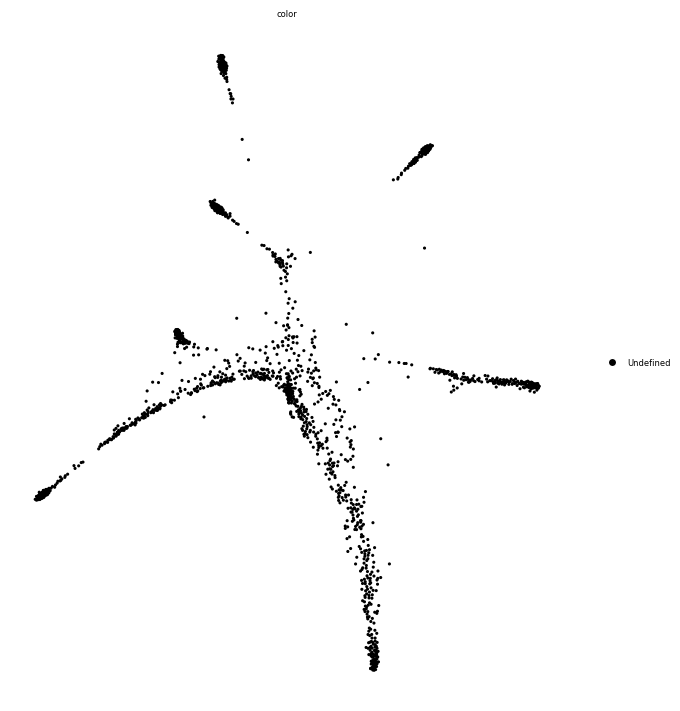

In [12]:
oci.pl.scatter(bmmc, x='X_proj', figsize=(7, 7), s=5)

To identify lineages, plot levels of selected protein markers. For example, CD71 (erythroid cells) and CD19 (B cells).

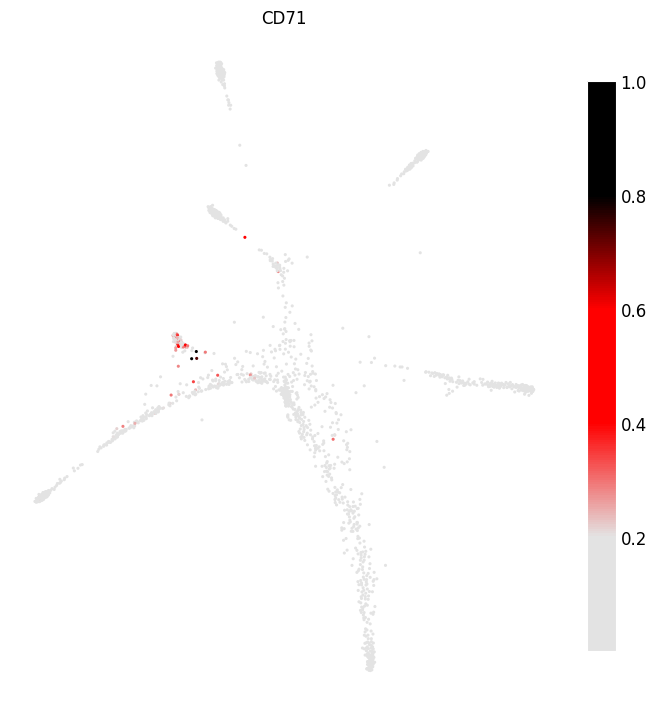

In [13]:
# a colormap for plotting
cmap = LinearSegmentedColormap.from_list('custom', ['#e3e3e3', '#e3e3e3',
                                                    '#ff0000', '#ff0000', 
                                                    '#000000', '#000000'], N=256)

# save normalized protein levels to bmmc.obs
cd71 = prot[:, 'CD71'].X.toarray().flatten()
bmmc.obs['CD71'] = cd71 / np.max(cd71)

oci.pl.scatter(bmmc, x='X_proj', c='CD71', cmap=cmap, figsize=(7, 7), s=5, 
               fontsize=12)

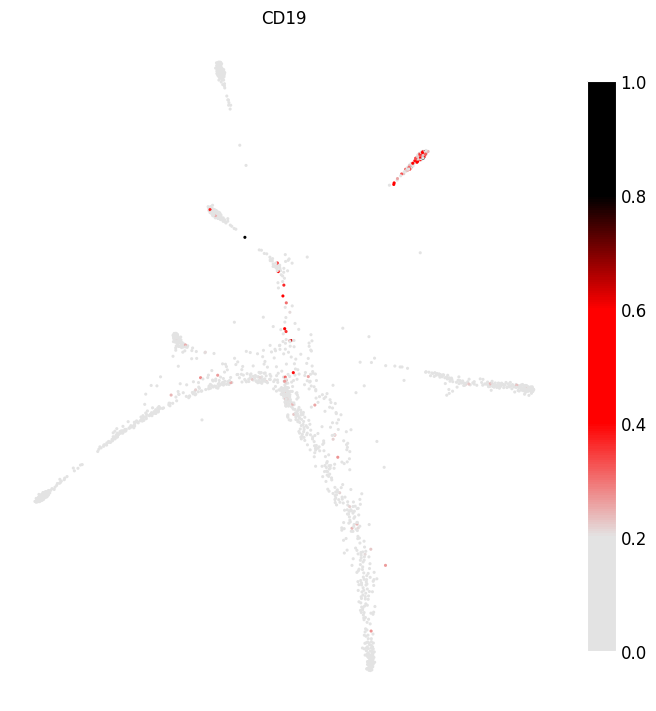

In [14]:
cd19 = prot[:, 'CD19'].X.toarray().flatten()
bmmc.obs['CD19'] = cd19 / np.max(cd19)

oci.pl.scatter(bmmc, x='X_proj', c='CD19', cmap=cmap, figsize=(7, 7), s=5, 
               fontsize=12)

Multimodal diffusion from a selected subpopulation of cells enables more accurate analysis of developmental trajectories in the large single-cell datasets, for example in single-cell studies of organogenesis.

In Tutorial 6, you will apply Ocelli to a BMMCs dataset profiled with NTT-seq.